<a href="https://colab.research.google.com/github/IvanKatorgin/NLP/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B5%D1%81%D1%82%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D1%8F%D0%B7%D1%8B%D0%BA%D0%B0_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Обработка естественного языка". Домашнее задание 1. Тематическое моделирование. Каторгин И.П.

## Задание
Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

In [3]:
# загрузим библиотеки
import json

import bz2
import regex
#from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()
from scipy import sparse
import codecs
import random

In [6]:
import numpy as np

In [7]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [8]:
# загрузим файл
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

0it [00:00, ?it/s]

Посмотрим на пример отзыва:

In [5]:
# посмотрим на пример отзыва
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречаются слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [9]:
# создадим датафрейм с отзывами
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


Проведем разведочный анализ данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [8]:
# посмотрим на пропуски
df.isnull().sum()

,0
city,15174
rating_not_checked,0
title,0
num_comments,0
bank_license,1
author,20
bank_name,0
datetime,0
text,0
rating_grade,64841


In [9]:
# посчитаем процент пропусков
((df.isnull().sum() / df.shape[0]) * 100).round(2)

,0
city,9.89
rating_not_checked,0.00
title,0.00
num_comments,0.00
bank_license,0.00
author,0.01
bank_name,0.00
datetime,0.00
text,0.00
rating_grade,42.24


In [10]:
df['rating_grade'].value_counts()

,count
rating_grade,
1.0,47387
5.0,14713
2.0,13509
3.0,9261
4.0,3788


In [11]:
df['rating_grade'].unique()

array([nan,  2.,  1.,  5.,  3.,  4.])

42% пропусков в столбце рейтинга - это очень много, их оставим без изменений. Пропуски в столбце с авторами объединим в отдельную группу, пропуски в городах объединим в отдельную группу, а пропуск в лицензии банка заполним исходя из названия банка

In [10]:
# заменим пропуски в столбце city на "город неизвестен":
df['city'].fillna('город неизвестен', inplace=True)
df['author'].fillna('автор неизвестен', inplace=True)
df

<ipython-input-10-b4cc1a479792>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['city'].fillna('город неизвестен', inplace=True)
<ipython-input-10-b4cc1a479792>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,город неизвестен,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,город неизвестен,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,город неизвестен,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,город неизвестен,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [11]:
# найдем банк без лицензии
filter_df = df[df['bank_license'].isna()]
filter_df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
45693,г. Москва,False,Промо-код,0,None,SemenovTV,Тульский Промышленник — Московский офис,2014-06-01 15:41:00,"Здравствуйте! 31 мая 2014 г. открыл в офисе ""М...",NaN


In [12]:
# найдем банк без лицензии
df[df['bank_name'] == 'Тульский Промышленник — Московский офис']

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
45693,г. Москва,False,Промо-код,0,None,SemenovTV,Тульский Промышленник — Московский офис,2014-06-01 15:41:00,"Здравствуйте! 31 мая 2014 г. открыл в офисе ""М...",NaN


Возможно это банк "Тульский промышленник". Отфильтруем его

In [13]:
# найдем банк без лицензии
df[df['bank_name'] == 'Тульский Промышленник']

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
10508,г. Москва,False,Отказ в обслуживании,0,лицензия № 2382,vbanki,Тульский Промышленник,2015-03-07 16:57:00,Мой третий визит в это отделение. 7.03.2015 в ...,NaN
21399,г. Москва,False,Доходчиво и благожелательно всё объяснили!,0,лицензия № 2382,rvv,Тульский Промышленник,2014-12-22 16:35:00,"Так уж получилось, что хотел открыть р/с в дан...",5.0
67093,г. Тула,False,Отлаженная работа. Приятное общение,0,лицензия № 2382,scorpionsha,Тульский Промышленник,2013-11-20 13:27:00,"Являюсь клиенткой банка с 2004г - ИП. И, хотя ...",5.0
67648,г. Новомосковск,False,Самый подходящий банк для малого бизнеса,4,лицензия № 2382,sysoy,Тульский Промышленник,2013-11-14 13:24:00,Добрый день. Решил написать отзыв и поддержать...,5.0
69505,г. Тула,False,Нормальный банк,0,лицензия № 2382,Wale,Тульский Промышленник,2013-10-28 22:26:00,Являюсь клиентом банка более 10 лет. Так как б...,5.0


In [14]:
# скорее всего банк Тульский Промышленник — Московский офис и банк Тульский Промышленник одни и тот же банк. Переименуем его и добавим лицензию
df.loc[df['bank_name'] == 'Тульский Промышленник — Московский офис', 'bank_name'] = 'Тульский Промышленник'

In [15]:
# заполним пропуски в столбце bank_license
df['bank_license'].fillna('лицензия № 2382', inplace=True)
df

<ipython-input-15-aca033192a68>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bank_license'].fillna('лицензия № 2382', inplace=True)


,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,город неизвестен,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,город неизвестен,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,город неизвестен,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,город неизвестен,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [18]:
# еще раз посмотрим на пропуски
df.isnull().sum()

,0
city,0
rating_not_checked,0
title,0
num_comments,0
bank_license,0
author,0
bank_name,0
datetime,0
text,0
rating_grade,64841


In [19]:
# посчитаем процент пропусков
((df.isnull().sum() / df.shape[0]) * 100).round(2)

,0
city,0.00
rating_not_checked,0.00
title,0.00
num_comments,0.00
bank_license,0.00
author,0.00
bank_name,0.00
datetime,0.00
text,0.00
rating_grade,42.24


Остались пропуски только в поле рейтинга, но с ними ничего делать не будем, т.к. их слишком много

Посмотрим на названия банков

In [16]:
sorted(df.bank_name.unique())

['2Т Банк',
 'АБ Финанс',
 'АББ',
 'АМБ Банк',
 'АМТ Банк',
 'АФ Банк',
 'Абсолют Банк',
 'Авангард',
 'Аверс',
 'Автоградбанк',
 'Автоторгбанк',
 'Агропромкредит',
 'Агророс',
 'Агросоюз',
 'Агрохимбанк',
 'Адамон Банк',
 'Адмиралтейский',
 'Азиатско-Тихоокеанский Банк',
 'Ай-Си-Ай-Си-Ай Банк (ICICI)',
 'АйМаниБанк',
 'Айви Банк',
 'Ак Барс',
 'Академический Русский Банк',
 'Акибанк',
 'Аксонбанк',
 'АктивКапитал Банк',
 'Акцент',
 'Акцепт',
 'Алданзолотобанк',
 'Александровский',
 'Алеф-Банк',
 'Алмазэргиэнбанк',
 'Алтынбанк',
 'Альта-Банк',
 'Альфа-Банк',
 'Анелик РУ',
 'Анкор Банк',
 'Анталбанк',
 'Арксбанк',
 'Аспект',
 'ББР Банк',
 'БИНБАНК кредитные карты',
 'БКС — Инвестиционный Банк',
 'БМВ Банк',
 'БНП Париба Банк',
 'БСТ-Банк',
 'БФГ-Кредит',
 'БайкалБанк',
 'БайкалИнвестБанк',
 'Байкалкредобанк',
 'Балтийский Банк',
 'Балтика',
 'Балтинвестбанк',
 'Банк «МБА-Москва»',
 'Банк «Санкт-Петербург»',
 'Банк АВБ',
 'Банк БКФ',
 'Банк БФА',
 'Банк БФТ',
 'Банк БЦК-Москва',
 'Банк В

Есть явно дублирующие названия, например ВТБ, ВТБ 24, ВТБ Северо-Запад. Посмотрим на лицензии банков и сопоставим количество уникальных лицензий с количеством уникуальных названий банков

In [17]:
df['bank_name'].unique().shape

(669,)

In [18]:
df['bank_license'].unique().shape

(670,)

Интересно, что количество уникальных лицензий больше, чем количество уникальных банков. Значит у одного какого-то банка есть две лицензии? Как так? Пока непонятно

In [19]:
# посмотрим на банк втб
filtered_df = df[(df['bank_name'] == 'ВТБ') | (df['bank_name'] == 'ВТБ 24') | (df['bank_name'] == 'ВТБ Северо-Запад')]
print(filtered_df['bank_license'].unique())
print(filtered_df['bank_license'].unique().shape)

['лицензия № 1623' 'лицензия № 1000' 'лицензия № 439 (аннулирована)']
(3,)


Три  разных банка

Найдем банк, у которого две лицензии

In [20]:
# Группировка по bank_name и сбор уникальных лицензий
bank_licenses = df.groupby('bank_name')['bank_license'].unique()

# Фильтрация банков с двумя или более лицензиями
banks_with_multiple_licenses = bank_licenses[bank_licenses.apply(len) >= 2]

# Вывод результата
print("Банки с двумя или более лицензиями:")
print(banks_with_multiple_licenses)

Банки с двумя или более лицензиями:
bank_name
Первомайский    [лицензия № 518, лицензия № 652 (отозвана)]
Name: bank_license, dtype: object


У банка Первомайский две разные лицензии. Для удобства отозванную лицензию заменим на основную

In [21]:
# заменим лицензию № 652 (отозвана) на лицензию № 518
df.loc[df['bank_license'] == 'лицензия № 652 (отозвана)', 'bank_license'] = 'лицензия № 518'

In [22]:
df['bank_name'].unique().shape

(669,)

In [23]:
df['bank_license'].unique().shape

(669,)

Теперь количество банков и количество лицензий совпадает

Посмотрим на названия городов

In [24]:
# посмотрим на названия городов
df['city'].value_counts()

,count
city,
г. Москва,55354
город неизвестен,15174
г. Санкт-Петербург,14342
г. Екатеринбург,2337
г. Новосибирск,2300
...,...
г. г. Березовский,1
г. геленджик,1
"г. п. Нахабино, Красногорского района",1


In [25]:
df['city'].unique().shape

(5824,)

Тут подный бедлам. Попробуем что-то сделать

In [26]:
!pip install yargy==0.12.0

In [27]:
!pip install natasha==0.10.0

In [28]:
from natasha import LocationExtractor

In [29]:
def extract_city(text):
    if isinstance(text, str):
        extractor = LocationExtractor()
        matches = extractor(text)
        if len(matches) > 0:
            return matches[0].fact.name
        else:
            return None
    else:
        return None

In [30]:
cities = pd.DataFrame(df.city.unique(), columns=['orig_name'])
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   orig_name  5824 non-null   object
dtypes: object(1)
memory usage: 45.6+ KB


In [31]:
cities['clean_name'] = cities['orig_name'].progress_apply(extract_city)

  0%|          | 0/5824 [00:00<?, ?it/s]

In [32]:
cities

,orig_name,clean_name
0,г. Москва,москва
1,г. Новосибирск,новосибирск
2,г. Ставрополь,ставрополь
3,г. Челябинск,челябинск
4,г. Волгоград,волгоград
...,...,...
5819,"г. Москва, павелецкое отделение",москва
5820,г. вся РФ,None
5821,г. Москва-Владимир,москва
5822,г. СПб.,None


In [33]:
cities.clean_name.count()

4773

In [34]:
cities.clean_name.value_counts()

,count
clean_name,
москва,359
петербург,124
московская область,51
ростов,51
московская обл,39
...,...
коченевое,1
стародуб,1
бакал,1


In [35]:
df['clean_city'] = df['city'].replace(cities['orig_name'].tolist(), cities['clean_name'].tolist())

In [36]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clean_city
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,новосибирск
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,москва
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,ставрополь
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,челябинск


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                153499 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153499 non-null  object 
 5   author              153499 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
 10  clean_city          135080 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 11.9+ MB


In [42]:
# еще раз посмотрим на пропуски
df.isnull().sum()

,0
city,0
rating_not_checked,0
title,0
num_comments,0
bank_license,0
author,0
bank_name,0
datetime,0
text,0
rating_grade,64841


In [43]:
# посчитаем процент пропусков
((df.isnull().sum() / df.shape[0]) * 100).round(2)

,0
city,0.00
rating_not_checked,0.00
title,0.00
num_comments,0.00
bank_license,0.00
author,0.00
bank_name,0.00
datetime,0.00
text,0.00
rating_grade,42.24


Clean_city имеют пропуски. Предлагается удалить эти строки, а также удалить столбец city и далее работать только с clean_city

In [38]:
# удалим строки с пропусками в clean_city
df = df.dropna(subset=['clean_city'])
df.isnull().sum()

,0
city,0
rating_not_checked,0
title,0
num_comments,0
bank_license,0
author,0
bank_name,0
datetime,0
text,0
rating_grade,61929


In [39]:
# удалим столбец city
df_new = df.drop(['city'], axis=1)
df_new

,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clean_city
0,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва
1,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,новосибирск
2,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,москва
3,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,ставрополь
4,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,челябинск
...,...,...,...,...,...,...,...,...,...,...
138574,False,Хамство сотрудника Павловского ОСБ,0,лицензия № 1481,Cto_IV,Сбербанк России,2009-07-05 15:48:00,Являюсь вкладчиком Павловского ОСБ № 1813 Юго-...,2.0,краснодарский край
138576,False,"Не поступили деньги, внесенные через банкомат....",10,лицензия № 2557,V1adimir,Ситибанк,2009-07-05 16:32:00,27 мая 2009 года внес 60 тыс. руб. через банко...,1.0,москва
138578,False,Мое мнение о банке,4,лицензия № 2771,Mellissa,Юниаструм Банк,2009-07-04 10:56:00,"Почитала я тут отзывы о своем банке, карта кот...",5.0,москва
138585,False,Банк в течении месяца не может проверить заемщика,0,лицензия № 2827,roma095,БИНБАНК кредитные карты,2009-07-04 10:10:00,После кражи карты предыдущего банка GEMONEY ре...,1.0,москва


In [46]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135080 entries, 0 to 138946
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   rating_not_checked  135080 non-null  bool   
 1   title               135080 non-null  object 
 2   num_comments        135080 non-null  int64  
 3   bank_license        135080 non-null  object 
 4   author              135080 non-null  object 
 5   bank_name           135080 non-null  object 
 6   datetime            135080 non-null  object 
 7   text                135080 non-null  object 
 8   rating_grade        73151 non-null   float64
 9   clean_city          135080 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.4+ MB


In [ ]:
# Посчитайте количество отзывов в разных городах и на разные банки
for col in ['clean_city', 'bank_name']:
    print(df[col].value_counts().sort_values(ascending=False))
    print('\n')

clean_city
москва          57300
петербург       15403
новосибирск      2400
екатеринбург     2397
ростов           2090
                ...  
булгаковое          1
свердловск          1
актау               1
семибратовое        1
челяинск            1
Name: count, Length: 1532, dtype: int64


bank_name
Сбербанк России           24701
Альфа-Банк                 8911
Хоум Кредит Банк           7147
ВТБ 24                     7143
Русский Стандарт           7053
                          ...  
Гранд Инвест Банк             1
Хованский                     1
Кошелев-Банк                  1
Град-Банк                     1
Нижегородпромстройбанк        1
Name: count, Length: 594, dtype: int64




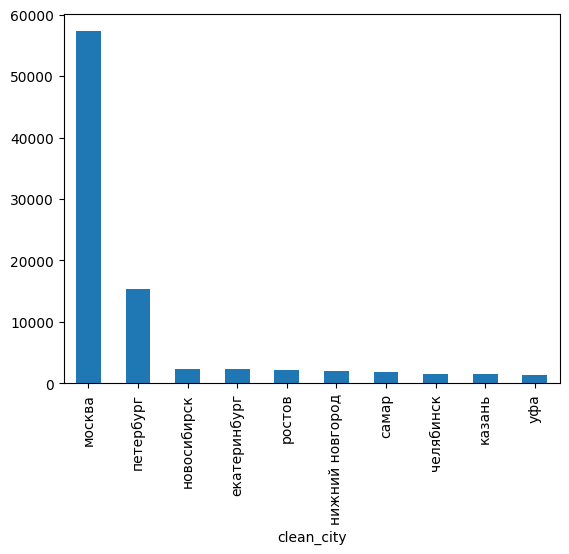

In [ ]:
# построим график самых популярных городов по отзывам
df_new['clean_city'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

Ожидаемо

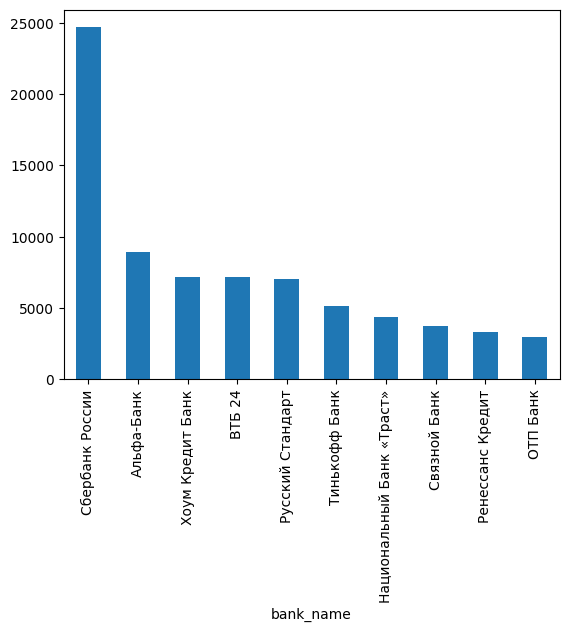

In [ ]:
# построим график самых популярных банков по отзывам
df_new['bank_name'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

Тоже ожидаемо

In [ ]:
# Посчитаем количество отзывов в каждом городе на разные банки и сгруппируем по городам
for col in ['clean_city']:
    print(df.groupby([col])['bank_name'].value_counts().sort_values(ascending=False))
    print('\n')

clean_city  bank_name                     
москва      Сбербанк России                   8435
            Альфа-Банк                        4006
            Русский Стандарт                  2930
            ВТБ 24                            2783
петербург   Сбербанк России                   2627
                                              ... 
нальчик     Райффайзенбанк                       1
            Национальный Банк «Траст»            1
            Московский Индустриальный Банк       1
            Бум-Банк                             1
яхрома      ДельтаКредит                         1
Name: count, Length: 12132, dtype: int64




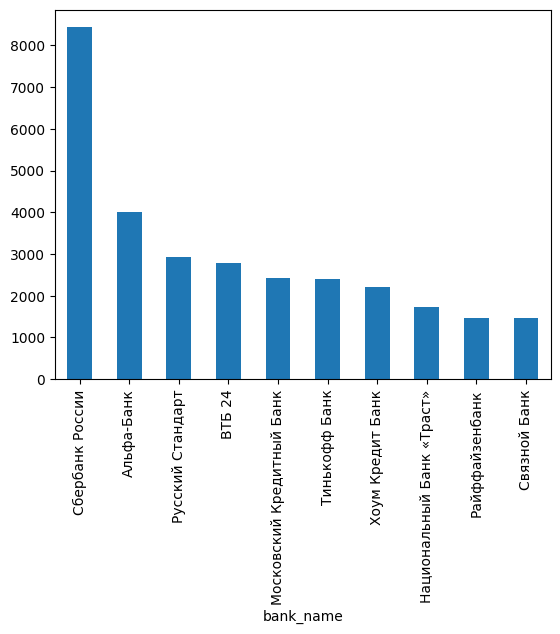

In [ ]:
# построим график самых популярных банков по отзывам в Москве
df_new[df_new['clean_city'] == 'москва']['bank_name'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

В целом повторяет структуру по России

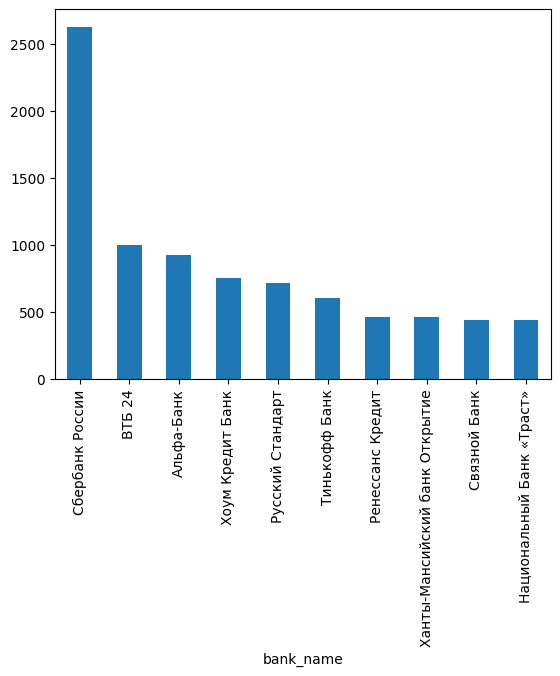

In [ ]:
# Посмотрим на Санкт-Петербург
df_new[df_new['clean_city'] == 'петербург']['bank_name'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

Тут тоже неожиданностей не произошло

In [ ]:
# Посчитаем количество отзывов в каждом городе на разные банки и сгруппируем по банкам
for col in ['bank_name']:
    print(df.groupby([col])['clean_city'].value_counts())
    print('\n')

bank_name      clean_city     
2Т Банк        москва             364
               петербург          168
               краснодар           11
               новороссийск        11
               нижний новгород      7
                                 ... 
Яндекс.Деньги  чебоксары            1
               череповец            1
Ярославич      москва               2
               ярославль            2
               рыбинск              1
Name: count, Length: 12132, dtype: int64




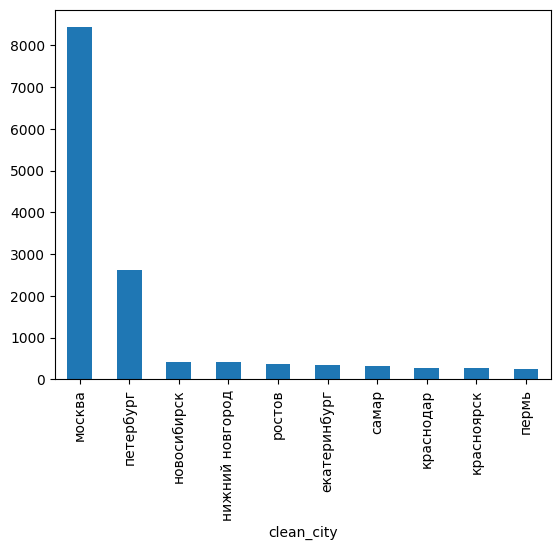

In [ ]:
# Посмотрим на Сбербанк
df_new[df_new['bank_name'] == 'Сбербанк России']['clean_city'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

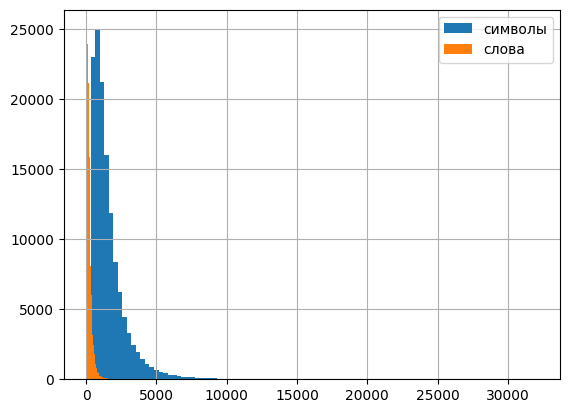

In [ ]:
# Постройте гистограмы длин слов в символах и в словах
df_new['text'].str.len().hist(bins=100)
df_new['text'].str.split().str.len().hist(bins=100)
# добавим легенду к гистограммам
plt.legend(['символы', 'слова'])
plt.show()

In [ ]:
# Найдем 10 самых частых слов
df_new['text'].str.split().explode().value_counts().head(10)

,count
text,
в,1031650
и,859232
не,722571
на,563653
что,524677
я,384440
с,378729
по,300446
-,251283


In [ ]:
from collections import Counter
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df_new.iterrows(), total = len(df)):
    tokens = row['text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

  0%|          | 0/135080 [00:00<?, ?it/s]

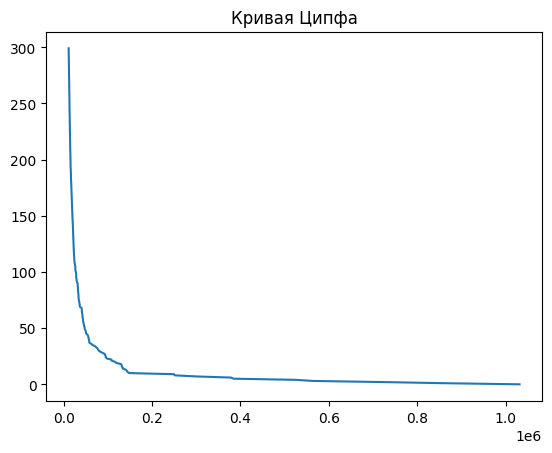

In [ ]:
# @title Кривая Ципфа

freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.title('Кривая Ципфа')
plt.show()

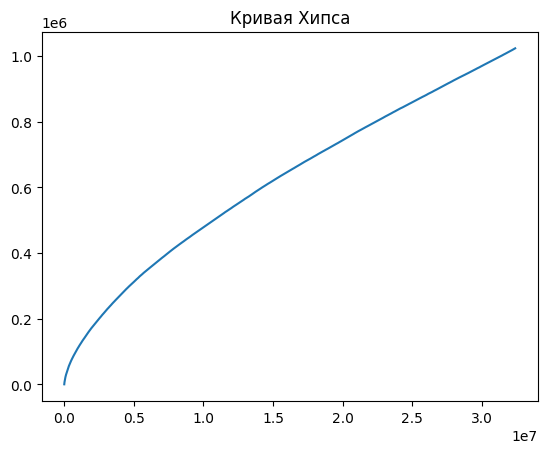

In [ ]:
# @title Кривая Хипса
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.title('Кривая Хипса')
plt.show()

In [40]:
# загрузим стоп-слова из библиотеки
from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'п', '-', 'В', 'И', 'на', 'На', 'Но', 'но', 'А', 'а', 'Я', ',', '.', '.', '-', '!', '!', '"', 'г', 'в', 'и', 'не', 'я']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Найдем 10 самых частых слов без стоп-слов
df_new['text'].str.split().explode().value_counts().drop(mystopwords).head(10)

,count
text,
банка,129732
банк,97765
деньги,79678
карты,58359
карту,57330
заявление,45339
очень,43853
отделение,42854
время,42166


Поскольку кривую хипса и ципфа мы уже один раз построили, а агрегирование данных для них занимает много времени, то просто построим график 10 самых популярных слов без стоп-слов

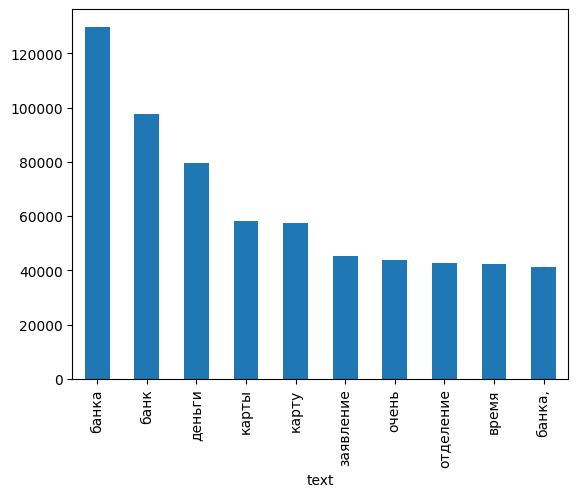

In [ ]:
# построим график самых частых слов без стоп-слов
df_new['text'].str.split().explode().value_counts().drop(mystopwords).head(10).plot(kind='bar')
plt.show()

In [41]:
# проведем лемматизацию
from pymystem3 import Mystem
m = Mystem()

In [42]:
# преобразуем текст в леммы
df_new['lemm_text'] = df_new['text'].apply(m.lemmatize)
df_new['lemm_text'].head()

,lemm_text
0,"[добрый, , день, ! , я, , не, , являться, ..."
1,"[добрый, , день, ! , являться, , держатель, ..."
2,"[здравствовать, ! , дублировать, , свой, , ..."
3,"[добрый, , день, !! , я, , открывать, , рас..."
4,"[04.03, ., 2015, , г, ., , взять, , кредит,..."


In [ ]:
# найдем 10 самых частых лемм
df_new['lemm_text'].explode().value_counts().head(10)

,count
lemm_text,
,25668325
",",2840801
.,1611910
в,1183969
я,1008052
и,941405
не,760827
на,629431
что,584490


In [43]:
# удалим стоп-слова из лемм
mystopwords_1 = mystopwords + ['что', ' ']
df_new['lemm_text'] = df_new['lemm_text'].apply(lambda x: [word for word in x if word not in mystopwords_1])
df_new['lemm_text'].head()

,lemm_text
0,"[добрый, день, ! , являться, клиент, банк, пор..."
1,"[добрый, день, ! , являться, держатель, зарпла..."
2,"[здравствовать, ! , дублировать, свой, заявле..."
3,"[добрый, день, !! , открывать, расчетный, счет..."
4,"[04.03, 2015, взять, кредит, ваш, банк, , , за..."


In [ ]:
# найдем 10 самых частых лемм без стоп-слов
df_new['lemm_text'].explode().value_counts().head(10)

,count
lemm_text,
",",2840801
.,1611910
банк,551299
карта,304732
(,225901
-,195994
деньги,160396
день,155531
!,154092


Почему-то остались символы, хотя я их добавлял в стоп-слова. Как их удалить не знаю

In [ ]:
# найдем 10 самых частых существительных
from collections import Counter
from tqdm import tqdm
import pymorphy2

# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

# Функция для лемматизации и фильтрации существительных
def extract_nouns(text):
    tokens = text.split()  # Разделяем текст на слова
    nouns = []
    for token in tokens:
        parsed = morph.parse(token)[0]  # Анализируем слово
        if 'NOUN' in parsed.tag:  # Проверяем, является ли слово существительным
            nouns.append(parsed.normal_form)  # Добавляем нормальную форму слова
    return nouns

# Инициализация счетчика
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun = []

# Обработка DataFrame
for index, row in tqdm(df_new.iterrows(), total=len(df_new)):
    text = row['text']  # Получаем текст из столбца
    nouns = extract_nouns(text)  # Извлекаем существительные
    cnt_noun.update(nouns)  # Обновляем счетчик
    n_types_noun.append(len(cnt_noun))  # Количество уникальных существительных
#    n_tokens_noun.append(sum(list(cnt.values())))  # Общее количество существительных, но так считает слишком долго, поэтому немного схитрим
    n_tokens_noun.append(sum(cnt.values())) # Общее количество существительных

# Вывод 10 самых частых существительных
for word, freq in cnt_noun.most_common(10):
    print(word, freq)

100%|██████████| 135080/135080 [1:25:56<00:00, 26.20it/s]


банка 209153
карта 200384
банк 147680
деньга 114892
сотрудник 100130
отделение 97042
счёт 84632
кредит 83260
день 81021
сумма 78307


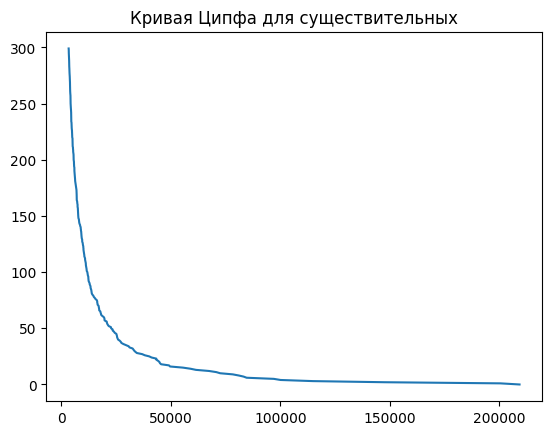

In [ ]:
# @title Кривая Ципфа для существительных

freqs = list(cnt_noun.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.title('Кривая Ципфа для существительных')
plt.show()

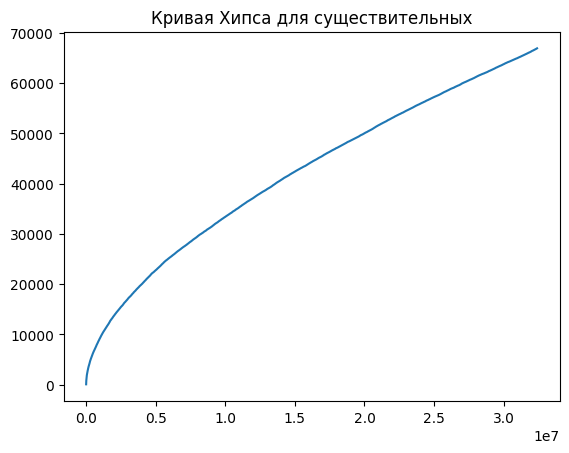

In [ ]:
# @title Кривая Хипса для существительных
fig, ax = plt.subplots()
#ax.plot(n_tokens_noun, n_types_noun)
ax.plot(n_tokens, n_types_noun)
plt.title('Кривая Хипса для существительных')
plt.show()

In [ ]:
print(f"слово \"сотрудник\" встречается {cnt['сотрудник']} раз")
print(f"слово \"клиент\" встречается {cnt['клиент']} раз")
if cnt['клиент'] > cnt['сотрудник']:
      print("слово \"клиент\" встречается чаще, чем слово \"сотрудник\"")
else:
      print("слово \"сотрудник\" встречается чаще, чем слово \"клиент\"")

слово "сотрудник" встречается 19860 раз
слово "клиент" встречается 9327 раз
слово "сотрудник" встречается чаще, чем слово "клиент"


In [ ]:
#сколько раз встречается слова "мошенничество" и "доверие"
print(f"слово \"мошенничество\" встречается {cnt['мошенничество']} раз")
print(f"слово \"доверие\" встречается {cnt['доверие']} раз")
if cnt['доверие'] > cnt['мошенничество']:
      print("слово \"доверие\" встречается чаще, чем слово \"мошенничество\"")
else:
      print("слово \"мошенничество\" встречается чаще, чем слово \"доверие\"")

слово "мошенничество" встречается 339 раз
слово "доверие" встречается 649 раз
слово "доверие" встречается чаще, чем слово "мошенничество"


Попробуем подсчитать тоже самое по леммам существительных

In [ ]:
print(f"лемма существительных \"сотрудник\" встречается {cnt_noun['сотрудник']} раз")
print(f"лемма существительных \"клиент\" встречается {cnt_noun['клиент']} раз")
if cnt_noun['клиент'] > cnt_noun['сотрудник']:
      print("лемма существительных \"клиент\" встречается чаще, чем лемма существительных \"сотрудник\"")
else:
      print("лемма существительных \"сотрудник\" встречается чаще, чем лемма существительных \"клиент\"")

лемма существительных "сотрудник" встречается 100130 раз
лемма существительных "клиент" встречается 72536 раз
лемма существительных "сотрудник" встречается чаще, чем лемма существительных "клиент"


In [ ]:
print(f"лемма существительных \"мошенничество\" встречается {cnt_noun['мошенничество']} раз")
print(f"лемма существительных \"доверие\" встречается {cnt_noun['доверие']} раз")
if cnt_noun['доверие'] > cnt_noun['мошенничество']:
      print("лемма существительных \"доверие\" встречается чаще, чем лемма существительных \"мошенничество\"")
else:
      print("лемма существительных \"мошенничество\" встречается чаще, чем лемма существительных \"доверие\"")

лемма существительных "мошенничество" встречается 1340 раз
лемма существительных "доверие" встречается 1303 раз
лемма существительных "мошенничество" встречается чаще, чем лемма существительных "доверие"


Соотношение слов "мошенничество" и "доверие" при подсчете через леммы существительных отличается от прямого подсчета

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  tf−idf , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
df_new['rating_grade'].fillna(0, inplace=True)
df_new['rating_grade'].unique()

<ipython-input-77-d52cda9e243e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new['rating_grade'].fillna(0, inplace=True)


array([0., 2., 1., 5., 3., 4.])

In [ ]:
tokens_by_rating = []
for rating in range(6):
    print(rating)
    tokens = []
    sample = df_new[df_new['rating_grade']==rating]

    for i in range(len(sample)):
        tokens += sample.iloc[i]['lemm_text']
    tokens_by_rating.append(tokens)

0
1
2
3
4
5


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Инициализация TfidfVectorizer с правильным значением min_df
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1)

# Преобразование текста в матрицу TF-IDF
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])

# Получение названий признаков (слов)
feature_names = tfidf.get_feature_names_out()

# Инициализация списка для хранения топ-40 слов
tfidf_ranking1_uni = []

# Преобразование разреженной матрицы в плотную
dense = tfidf_matrix.todense()

# Получение TF-IDF оценок для второго документа (индекс 1)
text = dense[1].tolist()[0]

# Фильтрация и сортировка слов по убыванию TF-IDF
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

# Сохранение топ-40 слов
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_uni.append(phrase)

# Вывод результата
print(tfidf_ranking1_uni)

['банк', 'карта', 'деньги', 'день', 'отделение', 'который', 'сотрудник', 'счет', 'кредит', 'сказать', 'клиент', 'мочь', 'заявление', 'весь', 'свой', 'сумма', 'получать', 'вопрос', 'год', 'время', 'приходить', 'ответ', 'то', 'сбербанк', 'офис', 'данный', 'платеж', 'звонить', 'телефон', 'кредитный', 'договор', 'номер', 'написать', 'обращаться', 'позвонить', 'банкомат', 'ваш', 'месяц', 'отвечать', 'средство']


Униграммы отрицательных отзывов

In [ ]:
rankings = pd.DataFrame({'negtive_uni': tfidf_ranking1_uni})
rankings.head(10)

,negtive_uni
0,банк
1,карта
2,деньги
3,день
4,отделение
5,который
6,сотрудник
7,счет
8,кредит
9,сказать


In [ ]:
# Инициализация TfidfVectorizer с правильным значением min_df
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1)

# Преобразование текста в матрицу TF-IDF
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])

# Получение названий признаков (слов)
feature_names = tfidf.get_feature_names_out()

# Инициализация списка для хранения топ-40 слов
tfidf_ranking1_bi = []

# Преобразование разреженной матрицы в плотную
dense = tfidf_matrix.todense()

# Получение TF-IDF оценок для второго документа (индекс 1)
text = dense[1].tolist()[0]

# Фильтрация и сортировка слов по убыванию TF-IDF
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

# Сохранение топ-40 слов
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_bi.append(phrase)

# Вывод результата
print(tfidf_ranking1_bi)

['сотрудник банк', 'денежный средство', 'отделение банк', 'написать заявление', 'какой то', 'кредитный карта', 'горячий линия', 'что то', 'колл центр', 'рабочий день', 'из за', 'ваш банк', 'интернет банк', 'клиент банк', 'служба поддержка', 'добрый день', 'альфа банк', 'сей пора', 'следующий день', 'приходить смс', 'досрочный погашение', 'кредитный история', 'получать ответ', 'обращаться отделение', 'деньги счет', 'данный банк', 'кредитный договор', 'писать заявление', 'номер телефон', 'отделение сбербанк', 'все таки', 'дебетовый карта', 'банк который', '2013 год', '000 рубль', '2014 год', 'являться клиент', 'офис банк', 'погашение кредит', 'свой деньги']


Биграммы отрицательных отзывов

In [ ]:
rankings = pd.DataFrame({'negative_bi': tfidf_ranking1_bi})
rankings.head(10)

,negative_bi
0,сотрудник банк
1,денежный средство
2,отделение банк
3,написать заявление
4,какой то
5,кредитный карта
6,горячий линия
7,что то
8,колл центр
9,рабочий день


In [ ]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking5_uni = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_uni.append(phrase)

print(tfidf_ranking5_uni)

['банк', 'карта', 'весь', 'очень', 'клиент', 'день', 'кредит', 'сотрудник', 'который', 'отделение', 'вклад', 'деньги', 'год', 'свой', 'вопрос', 'офис', 'время', 'счет', 'работа', 'получать', 'мочь', 'обслуживание', 'спасибо', 'сказать', 'проблема', 'решать', 'хотеть', 'документ', 'кредитный', 'то', 'интернет', 'быстро', 'работать', 'сумма', 'банка', 'минута', 'приходить', 'открывать', 'очередь', 'оформлять']


Униграммы положительных отзывов

In [ ]:
rankings = pd.DataFrame({'positive_uni': tfidf_ranking5_uni})
rankings.head(10)

,positive_uni
0,банк
1,карта
2,весь
3,очень
4,клиент
5,день
6,кредит
7,сотрудник
8,который
9,отделение


In [ ]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 1)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking5_bi = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_bi.append(phrase)

print(tfidf_ranking5_bi)

['интернет банк', 'сотрудник банк', 'кредитный карта', 'клиент банк', 'какой то', 'открывать вклад', 'отделение банк', 'являться клиент', 'следующий день', 'весь вопрос', 'что то', 'добрый день', 'дебетовый карта', 'банк который', 'из за', 'колл центр', 'альфа банк', 'как то', 'хотеть выражать', 'приятно удивлять', 'процентный ставка', 'рабочий день', 'данный банк', 'работа банк', 'выражать благодарность', 'денежный средство', 'очень быстро', 'офис банк', 'карта банк', 'банк очень', 'год назад', 'очень довольный', 'пользоваться услуга', 'отношение клиент', 'все таки', 'большой спасибо', 'весь документ', 'услуга банк', 'написать заявление', 'кредитный лимит']


Биграммы положительных отзывов

In [ ]:
rankings = pd.DataFrame({'positive_bi': tfidf_ranking5_bi})
rankings.head(10)

,positive_bi
0,интернет банк
1,сотрудник банк
2,кредитный карта
3,клиент банк
4,какой то
5,открывать вклад
6,отделение банк
7,являться клиент
8,следующий день
9,весь вопрос


Сводная таблица

In [ ]:
rankings = pd.DataFrame({'negtive_uni': tfidf_ranking1_uni, 'negative_bi': tfidf_ranking1_bi, 'positive_uni': tfidf_ranking5_uni, 'positive_bi': tfidf_ranking5_bi})
rankings.head(10)

,negtive_uni,negative_bi,positive_uni,positive_bi
0,банк,сотрудник банк,банк,интернет банк
1,карта,денежный средство,карта,сотрудник банк
2,деньги,отделение банк,весь,кредитный карта
3,день,написать заявление,очень,клиент банк
4,отделение,какой то,клиент,какой то
5,который,кредитный карта,день,открывать вклад
6,сотрудник,горячий линия,кредит,отделение банк
7,счет,что то,сотрудник,являться клиент
8,кредит,колл центр,который,следующий день
9,сказать,рабочий день,отделение,весь вопрос


<Axes: >

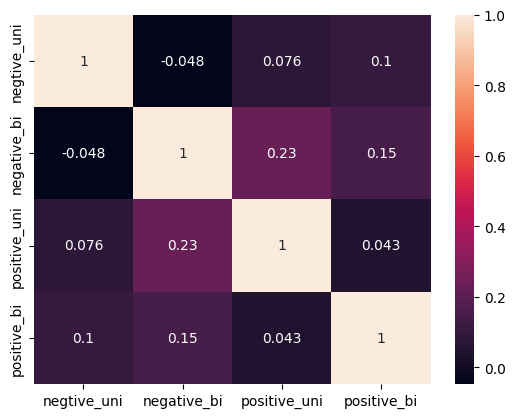

In [ ]:
from scipy.stats import spearmanr
import seaborn as sns
%matplotlib inline
corr = spearmanr(rankings).correlation
sns.heatmap(corr, annot=True, xticklabels = list(rankings), yticklabels = list(rankings))

## Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim.

In [5]:
!pip uninstall numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-2.0.2


In [1]:
!pip install numpy==1.23.5
!pip install gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but yo

In [51]:
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import ldamodel, TfidfModel
from gensim import similarities

In [55]:
# Преобразуем столбец в список списков
texts = df_new['lemm_text'].tolist()
# Создание словаря и корпуса
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [56]:
random.seed(42)

In [57]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 8min 3s, sys: 2min 56s, total: 11min
Wall time: 7min 56s


In [58]:
lda.show_topics(20)

[(0,
  '0.142*"сбербанк" + 0.055*"карта" + 0.052*", " + 0.045*". " + 0.044*"отделение" + 0.020*"№" + 0.018*"/" + 0.014*"онлайн" + 0.014*"СБ" + 0.013*"россия"'),
 (1,
  '0.094*", " + 0.065*". " + 0.061*"банкомат" + 0.060*"деньги" + 0.019*"день" + 0.015*"снимать" + 0.014*"карта" + 0.012*"сумма" + 0.011*"операция" + 0.011*"претензия"'),
 (2,
  '0.127*", " + 0.061*". " + 0.031*"заявка" + 0.024*"день" + 0.020*"документ" + 0.017*"сказать" + 0.016*"позвонить" + 0.015*"кредит" + 0.015*"оформлять" + 0.014*"банк"'),
 (3,
  '0.098*", " + 0.069*". " + 0.019*"очередь" + 0.019*"отделение" + 0.016*" (" + 0.015*"минута" + 0.014*"работать" + 0.011*"клиент" + 0.010*"касса" + 0.010*"офис"'),
 (4,
  '0.225*", " + 0.088*". " + 0.031*" - " + 0.013*"? " + 0.013*"банк" + 0.012*"... " + 0.010*"деньги" + 0.009*"мочь" + 0.008*"весь" + 0.008*"..."'),
 (5,
  '0.090*", " + 0.078*". " + 0.044*"банк" + 0.023*"вклад" + 0.013*"очень" + 0.013*"клиент" + 0.010*"открывать" + 0.009*"весь" + 0.008*" (" + 0.008*"\n"'),
 (6,


0. Карта Сбербанка
1. Режим работы банкомата
2. Заявка на кредит
3. Работа отделения
4. Что-то непонятное
5. Банковский вклад
6. Кредит от Альфа-Банка
7. Мобильный банк
8. Ипотека
9. Что-то непонятное
10. Кредитная карта
11. Договор с банком
12. Что-то непонятное
13. Что-то непонятное
14. Просрочка по кредиту
15. Обращение в банк
16. Размер комиссии
17. Что-то непонятное
18. Денежные переводы
19. Звонок из банка

In [59]:
%%time
lda15 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15, alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 6min 32s, sys: 58.9 s, total: 7min 31s
Wall time: 6min 35s


In [60]:
lda15.show_topics(15)

[(0,
  '0.037*"покупка" + 0.036*"доллар" + 0.035*"валюта" + 0.034*"евро" + 0.034*"курс" + 0.033*"магазин" + 0.027*"рубль" + 0.020*"сумма" + 0.017*", " + 0.017*". "'),
 (1,
  '0.062*"вклад" + 0.043*" "" + 0.040*". " + 0.037*" - " + 0.032*", " + 0.023*"" " + 0.021*"банк" + 0.019*" (" + 0.018*"процент" + 0.017*"открывать"'),
 (2,
  '0.103*"счет" + 0.043*". " + 0.042*"средство" + 0.039*", " + 0.038*"банк" + 0.031*"комиссия" + 0.028*"перевод" + 0.021*"сумма" + 0.020*"операция" + 0.018*"денежный"'),
 (3,
  '0.074*". " + 0.054*", " + 0.023*"интернет" + 0.020*" - " + 0.018*"услуга" + 0.015*"система" + 0.014*" (" + 0.013*"платеж" + 0.010*"поддержка" + 0.010*"банк"'),
 (4,
  '0.125*", " + 0.065*"деньги" + 0.061*". " + 0.053*"банкомат" + 0.020*"сбербанк" + 0.016*"карта" + 0.014*"снимать" + 0.012*"заявление" + 0.011*"день" + 0.009*"написать"'),
 (5,
  '0.163*"карта" + 0.105*", " + 0.063*". " + 0.016*"кредитный" + 0.013*"банк" + 0.013*"получать" + 0.012*"заявление" + 0.012*"лимит" + 0.009*"отделени

0. Покупка валюты
1. Вклады и депозиты
2. Комиссия за перевод
3. Интернет-поддержка?
4. Снятие денег из банкомата Сбербанка
5. Кредитная карта, лимит
6. Режим работы офиса
7. Кредитный договор
8. Что-то про Сбербанк
9. Какая-то претензия
10. Заявка на кредит
11. Обслуживание кредита
12. Звонок из банка
13. Что-то про сотрудника банка
14. Какие-то судебные тяжбы

In [61]:
%%time
lda10 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 5min 36s, sys: 6.11 s, total: 5min 42s
Wall time: 5min 53s


In [62]:
lda10.show_topics(10)

[(0,
  '0.102*", " + 0.067*". " + 0.041*"деньги" + 0.030*"банкомат" + 0.021*"заявление" + 0.020*"счет" + 0.015*"день" + 0.015*"банк" + 0.013*"карта" + 0.012*"отделение"'),
 (1,
  '0.102*", " + 0.073*". " + 0.035*"банк" + 0.014*"вклад" + 0.013*" - " + 0.013*"клиент" + 0.011*" "" + 0.011*" (" + 0.009*"очень" + 0.008*"весь"'),
 (2,
  '0.110*"карта" + 0.090*", " + 0.065*". " + 0.024*"банк" + 0.012*"кредитный" + 0.012*" (" + 0.009*"получать" + 0.009*"лимит" + 0.008*" - " + 0.008*".  "'),
 (3,
  '0.031*". " + 0.030*":" + 0.026*"сумма" + 0.023*" (" + 0.021*"рубль" + 0.021*"руб" + 0.019*": " + 0.017*"комиссия" + 0.017*") " + 0.015*"счет"'),
 (4,
  '0.051*", " + 0.032*" «" + 0.026*". " + 0.021*"банк" + 0.020*"/" + 0.018*" – " + 0.016*"» " + 0.015*"договор" + 0.014*"»" + 0.013*" ("'),
 (5,
  '0.054*". " + 0.036*", " + 0.019*"платеж" + 0.018*"банк" + 0.016*"перевод" + 0.015*"система" + 0.013*"интернет" + 0.012*"операция" + 0.012*"поддержка" + 0.011*"услуга"'),
 (6,
  '0.091*", " + 0.053*". " + 0.

0. Возможно банкомат не выдал деньги?
1. Банковский вклад
2. Кредитная карта
3. Тарифы, комиссии
4. Договор с банком
5. Переводы, платежи через интернет
6. Кредитный договор
7. Что-то непонятное
8. Работа отделения
9. Разговор по телефону с сотрудником

Разбиение на темы сильно зависит от генератора псевдослучайных чисел - разные сиды дают сильно разные темы.

## Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```),
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). Используйте accuracy и F-measure для оценки качества классификации.

Эта часть задания может быть сделана с использованием sklearn.

In [44]:
df_class = df_new.loc[df_new['rating_grade'].isin([1, 5])][['bank_name', 'clean_city', 'num_comments', 'lemm_text', 'rating_grade']].reset_index(drop=True)

In [45]:
df_class['rating'] = df_class['rating_grade'].apply(lambda x: 1 if x == 5 else 0)

In [46]:
df_class.to_pickle('df_class.zip')

In [47]:
df_class = pd.read_pickle('df_class.zip')

In [48]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49299 entries, 0 to 49298
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bank_name     49299 non-null  object 
 1   clean_city    49299 non-null  object 
 2   num_comments  49299 non-null  int64  
 3   lemm_text     49299 non-null  object 
 4   rating_grade  49299 non-null  float64
 5   rating        49299 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 2.3+ MB


In [49]:
df_class.head()

,bank_name,clean_city,num_comments,lemm_text,rating_grade,rating
0,Сбербанк России,москва,2,"[открывать, вклад, счет, USD, . , плюс, зарпла...",1.0,0
1,Сбербанк России,ростов,1,"[добрый, время, ! , вчера, поступать, смс, уве...",1.0,0
2,АктивКапитал Банк,петербург,0,"[05.06, 2015г, около, 15, час, , , приходить, ...",1.0,0
3,Сбербанк России,москва,4,"[оплата, коммунальный, платеж, пользоваться, п...",1.0,0
4,Сбербанк России,чапаевск,16,"[апрель, год, приходить, отделение, сбербанк, ...",1.0,0


In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [51]:
random.seed(42)

In [52]:
features = ['bank_name', 'clean_city', 'num_comments', 'lemm_text']
target = ['rating']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_class[features], df_class[target], test_size=0.2)

In [54]:
X_train.head()

,bank_name,clean_city,num_comments,lemm_text
25786,Русский Стандарт,москва,4,"[сегодня, месяц, проходить, пора, производить,..."
4346,Сбербанк России,москва,3,"[добрый, день, ! , помогать, разрешать, ситуац..."
46871,Сбербанк России,орёл,22,"[зарекаться, иметь, дело, сбер, , , напрасно, ..."
15813,Московский Кредитный Банк,мытищи,2,"[обслуживаться, мытищинский, офис, , , выбират..."
41276,Банк Москвы,москва,1,"[полный, неразбериха, чудовищный, бардак, цари..."


In [55]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [56]:
class ListToTextTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [' '.join(doc) for doc in X]

text1 = Pipeline([
    ('selector', TextSelector(key='lemm_text')),
    ('list_to_text', ListToTextTransformer()),
    ('cnt_vect', CountVectorizer()),
    ('tfidf_tr', TfidfTransformer()),
    ('lsa', TruncatedSVD(n_components=100))
])

text1.fit_transform(X_train)

array([[ 0.28543945,  0.08242977, -0.01907869, ..., -0.00780932,
        -0.02386845, -0.06085461],
       [ 0.33412145, -0.14105413, -0.21761106, ...,  0.00568235,
         0.00231553,  0.04440168],
       [ 0.26538728,  0.12689652,  0.02865859, ..., -0.00314189,
         0.0499365 ,  0.02670895],
       ...,
       [ 0.40093099,  0.05432771, -0.03284094, ...,  0.00481533,
         0.01138054, -0.00690266],
       [ 0.26401261,  0.27610501, -0.00547461, ...,  0.03455236,
        -0.02807538,  0.02330881],
       [ 0.35933324,  0.12694818, -0.01057009, ..., -0.00896142,
        -0.01113514, -0.04807831]])

In [57]:
num_comments = Pipeline([
    ('selector', ItemSelector(key='num_comments')),
    ('std_scaler', StandardScaler())
])
num_comments.fit_transform(X_train)

array([[ 0.07040434],
       [-0.09065579],
       [ 2.96948661],
       ...,
       [ 1.03676509],
       [-0.41277604],
       [ 0.55358471]])

In [58]:
bank_name = Pipeline([
    ('selector', ItemSelector(key='bank_name')),
    ('dict_vec', OneHotEncoder(categories=[df_class['bank_name'].unique()]))
])
bank_name.fit_transform(X_train)

<39439x498 sparse matrix of type '<class 'numpy.float64'>'
	with 39439 stored elements in Compressed Sparse Row format>

In [59]:
city = Pipeline([
    ('selector', ItemSelector(key='clean_city')),
    ('dict_vec', OneHotEncoder(categories=[df_class['clean_city'].unique()]))
])
city.fit_transform(X_train)

<39439x968 sparse matrix of type '<class 'numpy.float64'>'
	with 39439 stored elements in Compressed Sparse Row format>

In [60]:
features1 = FeatureUnion([
    ('text1', text1),
    ('num_comments', num_comments),
    ('bank_name', bank_name),
    ('city', city)
])

In [61]:
clf1 = Pipeline([
    ('features', features1),
    ('clf', RandomForestClassifier())
])
clf1.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text1',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='lemm_text')),
                                                                 ('list_to_text',
                                                                  <__main__.ListToTextTransformer object at 0x7dbb953ebb50>),
                                                                 ('cnt_vect',
                                                                  CountVectorizer()),
                                                                 ('tfidf_tr',
                                                                  TfidfTransformer()),
                                                                 ('lsa',
                                                                  TruncatedSVD(n_components=100))])),
                                                ('num_comments',
                                                 Pipeline(steps=[('selector',
                                                                  It...
       'белая калитва', 'усмань', 'семибратовое', 'балей', 'оханск',
       'хайфа', 'город череповец', 'верхняя салда', 'новчеркасск',
       'екатериновка', 'мордовия', 'санктпетербург',
       'костромская область', 'обуховое', 'оинцовое', 'гвардейск',
       'карелия', 'острогожск', 'город оленегорск', 'игрим',
       'город нижний новгород', 'город ульяновск', 'мсоква'], dtype=object)]))]))])),
                ('clf', RandomForestClassifier())])

In [62]:
preds = clf1.predict(X_test)
np.mean(preds == y_test['rating'])

0.8925963488843813

Precision:   0.94
Recall:   0.74
F1-measure:   0.79
Accuracy:   0.89
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      7840
           1       0.99      0.48      0.65      2020

    accuracy                           0.89      9860
   macro avg       0.94      0.74      0.79      9860
weighted avg       0.90      0.89      0.88      9860



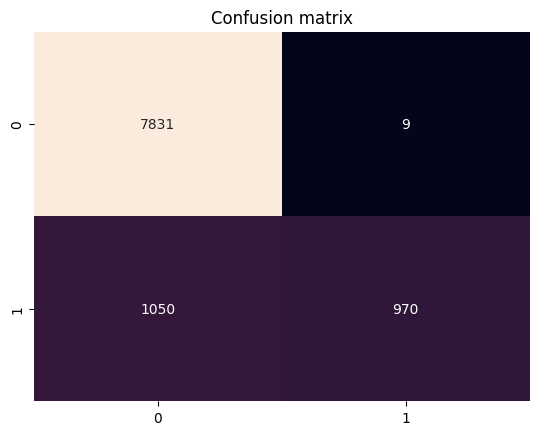

In [63]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf1.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Попробуем с подбром параметров

In [64]:
clf1.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'features', 'clf', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__verbose_feature_names_out', 'features__text1', 'features__num_comments', 'features__bank_name', 'features__city', 'features__text1__memory', 'features__text1__steps', 'features__text1__transform_input', 'features__text1__verbose', 'features__text1__selector', 'features__text1__list_to_text', 'features__text1__cnt_vect', 'features__text1__tfidf_tr', 'features__text1__lsa', 'features__text1__selector__key', 'features__text1__cnt_vect__analyzer', 'features__text1__cnt_vect__binary', 'features__text1__cnt_vect__decode_error', 'features__text1__cnt_vect__dtype', 'features__text1__cnt_vect__encoding', 'features__text1__cnt_vect__input', 'features__text1__cnt_vect__lowercase', 'features__text1__cnt_vect__max_df', 'features__text1__cnt_vect__max_features', 'features__text1__cnt_vect__min_df', 'features_

In [ ]:
hyperparams = {
    'features__text1__cnt_vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
}

grid1 = GridSearchCV(clf1, hyperparams, cv=5, verbose=10, n_jobs=4, scoring='f1')
grid1.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed: 15.4min remaining:  7.7min
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed: 39.5min remaining:  9.9min
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 47.2min finished
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text1', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='lemma')), ('cnt_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'features__text1__cnt_vect__ngram_range': [(1, 1), (2, 2), (3, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=10)

In [ ]:
print(grid1.best_params_)
print(grid1.best_score_)

{'features__text1__cnt_vect__ngram_range': (1, 1)}
0.5916851463021996


c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Precision:   0.88
Recall:   0.72
F1-measure:   0.76
Accuracy:   0.86
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      9472
           1       0.92      0.45      0.60      2948

   micro avg       0.86      0.86      0.86     12420
   macro avg       0.88      0.72      0.76     12420
weighted avg       0.87      0.86      0.84     12420



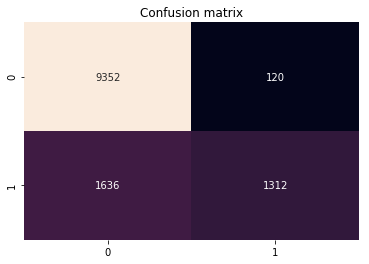

In [ ]:
preds = grid1.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf1.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Улучшить результат не получилось. Лучше всего работают униграммы.

In [ ]:
text2 = Pipeline([
    ('selector', TextSelector(key='lemm_text')),
    ('cnt_vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('tfidf_tr', TfidfTransformer()),
    ('lsa', TruncatedSVD(n_components=100))
])
text1.fit_transform(X_train)

array([[ 0.23625725, -0.09647917, -0.0267986 , ...,  0.03114487,
        -0.01029539,  0.00553989],
       [ 0.11917959, -0.05020567,  0.02002534, ...,  0.01256701,
        -0.02976576, -0.00952686],
       [ 0.26778566,  0.01497633,  0.13963541, ..., -0.00326588,
         0.00844652,  0.0209487 ],
       ...,
       [ 0.21163135,  0.03317291, -0.0199546 , ...,  0.05219903,
        -0.04639692, -0.01433147],
       [ 0.23514567,  0.07106686, -0.00293267, ...,  0.01853452,
        -0.00621342, -0.00063945],
       [ 0.36356512, -0.0639505 , -0.15439019, ..., -0.0135146 ,
        -0.03636106, -0.01062212]])

In [ ]:
features2 = FeatureUnion([
    ('text2', text2),
    ('num_comments', num_comments),
    ('bank_name', bank_name),
    ('city', city)
])

In [ ]:
clf2 = Pipeline([
    ('features', features2),
    ('clf', RandomForestClassifier())
])
clf2.fit(X_train, y_train)

c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text2', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='lemma')), ('cnt_vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [ ]:
preds = clf2.predict(X_test)
np.mean(preds == y_test['rating'])

c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8524154589371981

Precision:   0.88
Recall:   0.70
F1-measure:   0.74
Accuracy:   0.85
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      9472
           1       0.91      0.42      0.57      2948

   micro avg       0.85      0.85      0.85     12420
   macro avg       0.88      0.70      0.74     12420
weighted avg       0.86      0.85      0.83     12420



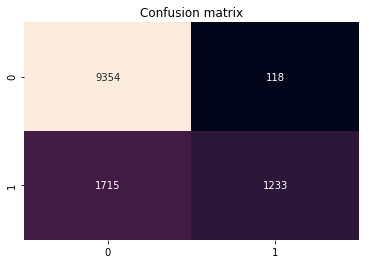

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf2.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Значительных различий между униграммами и символьным походом нет

In [ ]:
text3 = Pipeline([
    ('selector', TextSelector(key='lemm_text')),
    ('cnt_vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('tfidf_tr', TfidfTransformer()),
    ('lda', LatentDirichletAllocation(n_components=20, n_jobs=4, verbose=10))
])

In [ ]:
features3 = FeatureUnion([
    ('text3', text3),
    ('num_comments', num_comments),
    ('bank_name', bank_name),
    ('city', city)
])

In [ ]:
clf3 = Pipeline([
    ('features', features3),
    ('clf', RandomForestClassifier(n_jobs=4, verbose=10))
])
clf3.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  6.0min remaining:  6.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.1min finished


iteration: 1 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.3min remaining:  4.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.4min finished


iteration: 2 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min finished


iteration: 3 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min finished


iteration: 4 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min finished


iteration: 5 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min finished


iteration: 6 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 7 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 8 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 9 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.2s remaining:   36.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.6s remaining:   34.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.4s finished
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).tran

building tree 1 of 10building tree 2 of 10building tree 3 of 10building tree 4 of 10



building tree 5 of 10
building tree 6 of 10
building tree 7 of 10building tree 8 of 10

building tree 9 of 10

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s



building tree 10 of 10

[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.9s remaining:    0.8s


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.7s finished


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text3', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='lemma')), ('cnt_vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=..._jobs=4,
            oob_score=False, random_state=None, verbose=10,
            warm_start=False))])

In [ ]:
preds = clf3.predict(X_test)
np.mean(preds == y_test['rating'])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   12.2s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.3s finished
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


0.799597423510467

Precision:   0.76
Recall:   0.61
F1-measure:   0.63
Accuracy:   0.80
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      9472
           1       0.71      0.26      0.38      2948

   micro avg       0.80      0.80      0.80     12420
   macro avg       0.76      0.61      0.63     12420
weighted avg       0.79      0.80      0.76     12420



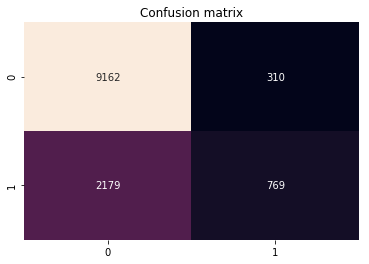

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf3.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

LDA отработало хуже, чем SVD. Возможно, это связано с меньшим количеством фичей (20 против 100). Ну и LDA работает медленнее, чем SVD

Уфф... Ну очень длинная и объемная домашка. Ее бы разделить на 2-3 домашки.